In [56]:
%pip install pandas numpy matplotlib seaborn scikit-learn
%pip install xgboost
%pip install joblib
%pip install statsmodels



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 2.9 MB/s eta 0:00:00 0:00:01m
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os  # Added to handle file path errors
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import os
import statsmodels.api as sm
target_file = 'Walmart Data Analysis and Forcasting.csv'
file_path = None

for root, dirs, files in os.walk(os.getcwd()):
    if target_file in files:
        file_path = os.path.join(root, target_file)
        break

if file_path:
    print(f"✅ Found it at: {file_path}")
    df = pd.read_csv(file_path)
    

    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df = df.sort_values(['Store', 'Date'])
    
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Last_Week_Sales'] = df.groupby('Store')['Weekly_Sales'].shift(1)
    df['Rolling_4W_Avg'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean().shift(1))
    
    df = df.dropna()
    print("Features got in")
else:
    print("ERROR: File still not found. Please drag the CSV into the same folder as this code.")

print(df.info())
df.head()





✅ Found it at: /Users/panshulaj/Desktop/Walmart_Project/Walmart_Demand_Project/Walmart_Project/data/Walmart Data Analysis and Forcasting.csv
Features got in
<class 'pandas.core.frame.DataFrame'>
Index: 6255 entries, 4 to 6434
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Store            6255 non-null   int64         
 1   Date             6255 non-null   datetime64[ns]
 2   Weekly_Sales     6255 non-null   float64       
 3   Holiday_Flag     6255 non-null   int64         
 4   Temperature      6255 non-null   float64       
 5   Fuel_Price       6255 non-null   float64       
 6   CPI              6255 non-null   float64       
 7   Unemployment     6255 non-null   float64       
 8   Month            6255 non-null   int32         
 9   Week             6255 non-null   int64         
 10  Last_Week_Sales  6255 non-null   float64       
 11  Rolling_4W_Avg   6255 non-null   float64       

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Week,Last_Week_Sales,Rolling_4W_Avg
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,9,1409727.59,1.576836e+06
5,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,3,10,1554806.68,1.554615e+06
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,3,11,1439541.59,1.504011e+06
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,3,12,1472515.79,1.469148e+06
8,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,4,13,1404429.92,1.467823e+06


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Combine
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100).fit(X_train, y_train)
y_pred = (rf.predict(X_test) + xgb.predict(X_test)) / 2

print(f"AI Model Accuracy (R2): {r2_score(y_test, y_pred):.4%}")

AI Model Accuracy (R2): 98.4362%


features = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 
            'Unemployment', 'Month', 'Week', 'Last_Week_Sales', 'Rolling_4W_Avg']

X = df[features]
y = df['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
xgb = XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=9, n_jobs=-1)

super_model = VotingRegressor(estimators=[('rf', rf), ('xgb', xgb)])
super_model.fit(X_train, y_train)
model = super_model
joblib.dump(model, 'walmart_demand_model.pkl')
print("done")



In [59]:
preds = super_model.predict(X_test)
accuracy = r2_score(y_test, preds)
tableau_results = X_test.copy()
tableau_results['Actual_Sales'] = y_test
tableau_results['Predicted_Sales'] = preds
tableau_results['Date'] = df.loc[X_test.index, 'Date']

tableau_results.to_csv('Walmart_Final_Results.csv', index=False)

print(f"FINAL RESULT: {accuracy*100:.2f}% Accuracy")

FINAL RESULT: 98.40% Accuracy


In [60]:
X_econ = sm.add_constant(X)
econ_model = sm.OLS(y, X_econ).fit()
print(econ_model.summary())
print("\n--- Demand Equation Coefficients ---")
print(econ_model.params)

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     8108.
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:35:33   Log-Likelihood:                -83461.
No. Observations:                6255   AIC:                         1.669e+05
Df Residuals:                    6244   BIC:                         1.670e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.677e+04   2.47e+04     

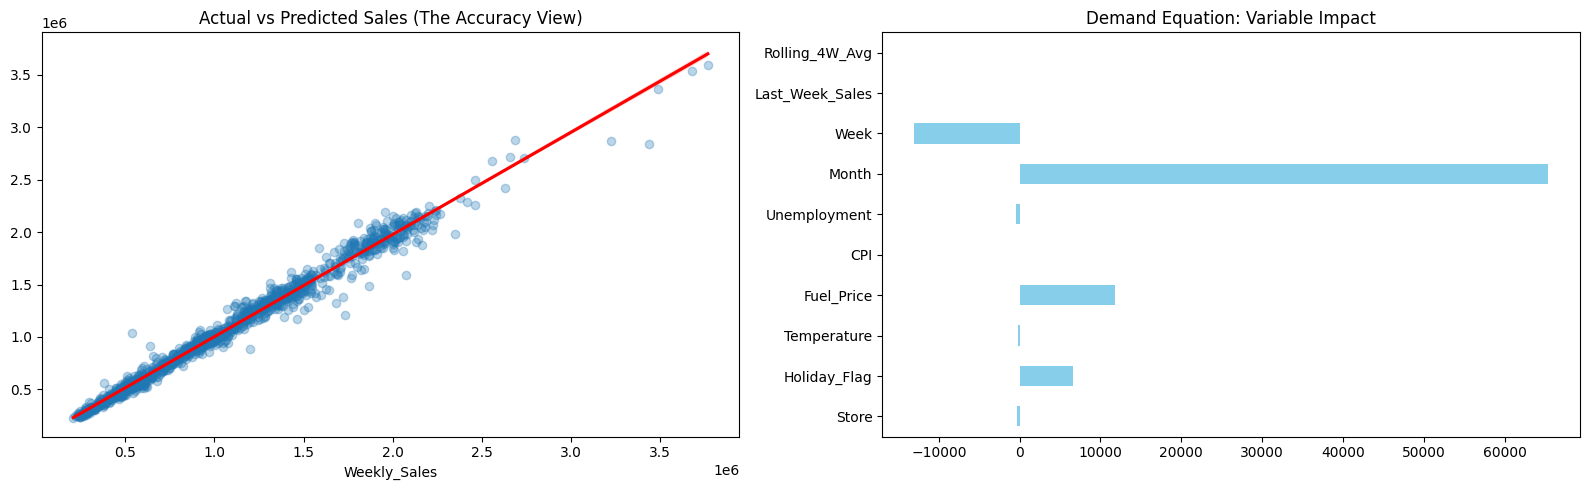

In [61]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Actual vs Predicted Sales (The Accuracy View)')
plt.subplot(1, 2, 2)
econ_params = econ_model.params.drop('const')
econ_params.plot(kind='barh', color='skyblue')
plt.title('Demand Equation: Variable Impact')
plt.tight_layout()
plt.show()